In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
from utils.ci import bootstrap_ci
from utils.visulize import plot_grouped_bar_with_ci
from utils.grouping import get_group_labels

In [2]:
# load data
df = pd.read_csv('./summary_results.csv')
dataset_name = "CON"  # Change to 'CF', 'CON', etc., for other comparisons
df = df[df['dataset'] == dataset_name].copy()

# ensure df has 240 rows excluding the title row
assert df.shape[0] == 240, f"Expected 240 rows, but got {df.shape[0]} rows."

In [3]:
print(df.columns)
metric_names = ['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc']
models = df['model'].unique()

Index(['dataset', 'seed', 'model', 'accuracy', 'f1_score', 'precision',
       'recall', 'roc_auc'],
      dtype='object')



===== ACCURACY =====
Kruskal-Wallis: H = 100.113, p = 0.0000

Post-hoc Dunn’s test (Holm-corrected):
                  logistic      lstm  lstm-features       lstmfcn  \
logistic          1.000000  1.000000   1.000000e+00  2.343186e-04   
lstm              1.000000  1.000000   1.000000e+00  5.440609e-04   
lstm-features     1.000000  1.000000   1.000000e+00  1.792010e-06   
lstmfcn           0.000234  0.000544   1.792010e-06  1.000000e+00   
lstmfcn-features  0.035263  0.058838   8.631874e-04  1.000000e+00   
randomforest      0.047792  0.077370   1.310442e-03  1.000000e+00   
svm               0.426542  0.291454   1.000000e+00  5.058570e-09   
vivit             0.000002  0.000005   4.940206e-09  1.000000e+00   

                  lstmfcn-features  randomforest           svm         vivit  
logistic                  0.035263      0.047792  4.265420e-01  1.880330e-06  
lstm                      0.058838      0.077370  2.914544e-01  5.322650e-06  
lstm-features             0.000863     

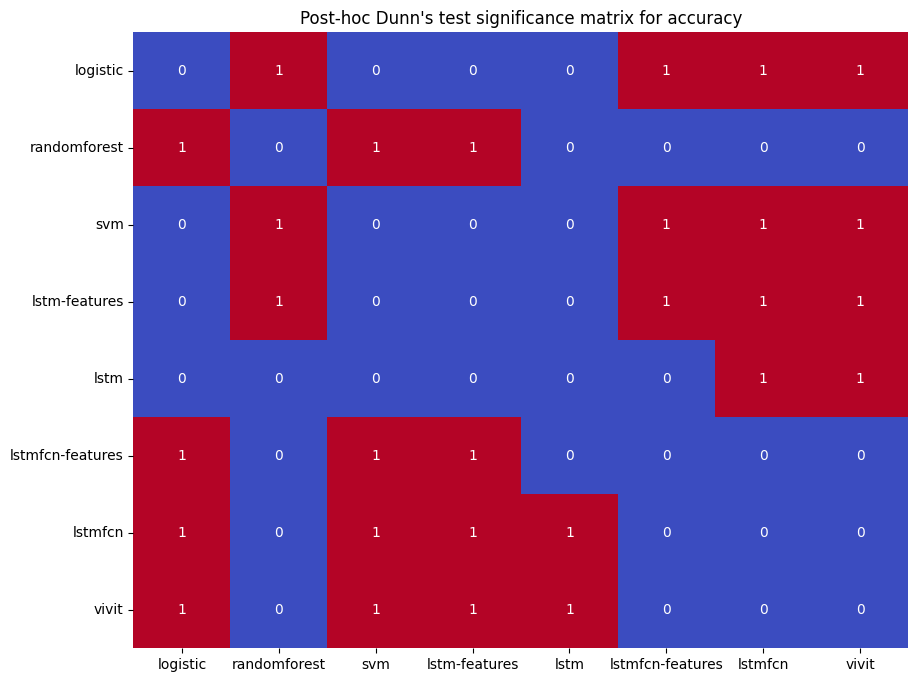

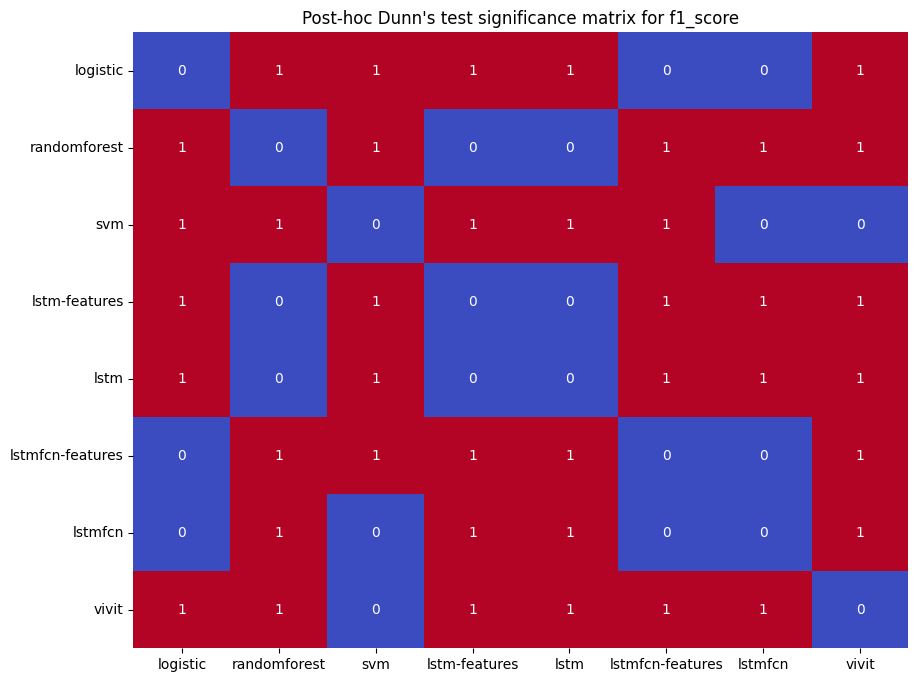

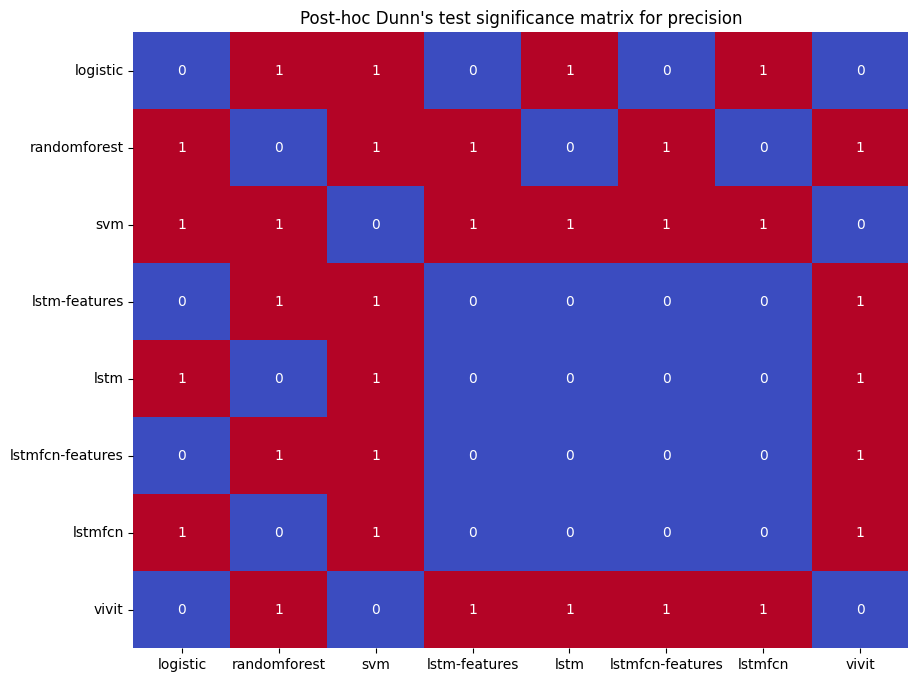

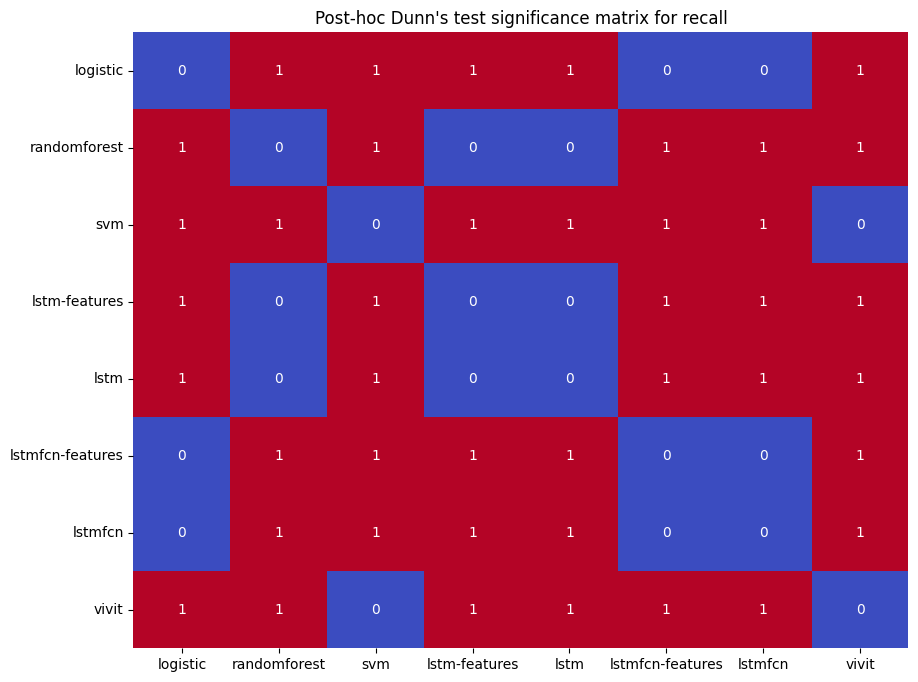

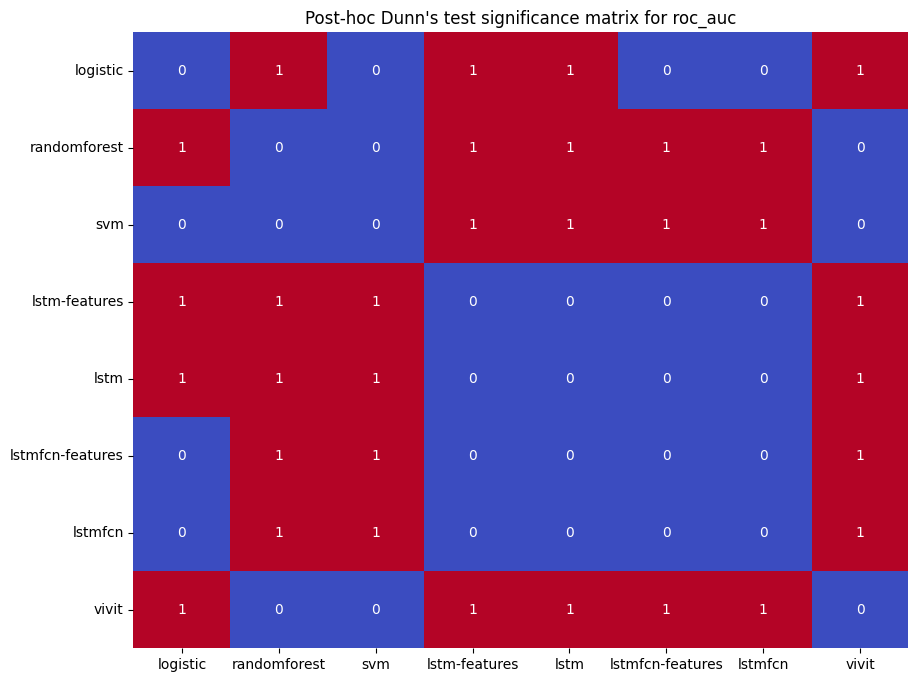

In [4]:
# Run analysis per metric
posthoc_results = {}
for metric in metric_names:
    print(f"\n===== {metric.upper()} =====")
    data_by_model = [df[df['model'] == m][metric] for m in models]

    # Kruskal-Wallis test
    H, p = kruskal(*data_by_model)
    print(f"Kruskal-Wallis: H = {H:.3f}, p = {p:.4f}")
    
    # Post-hoc test if significant
    if p < 0.05:
        posthoc = sp.posthoc_dunn(df, val_col=metric, group_col='model', p_adjust='holm')
        posthoc_results[metric] = posthoc
        print("\nPost-hoc Dunn’s test (Holm-corrected):")
        print(posthoc)

        sig_plot = posthoc.apply(lambda x: x < 0.05).astype(int)
        # Plotting the significance matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(sig_plot.loc[models, models], annot=True, cmap='coolwarm', cbar=False)
        plt.title(f"Post-hoc Dunn's test significance matrix for {metric}")
    else:
        print("No statistically significant difference among models.")

In [5]:
group_labels_per_metric = get_group_labels(posthoc_results, alpha=0.05)
print(group_labels_per_metric)


{'accuracy': {'lstmfcn': 'A', 'lstmfcn-features': 'A', 'randomforest': 'A', 'vivit': 'A', 'logistic': 'B', 'lstm': 'B', 'lstm-features': 'B', 'svm': 'B'}, 'f1_score': {'lstm': 'A', 'lstm-features': 'A', 'randomforest': 'A', 'logistic': 'B', 'lstmfcn': 'B', 'lstmfcn-features': 'B', 'svm': 'C', 'vivit': 'D'}, 'precision': {'lstm': 'A', 'lstm-features': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'randomforest': 'B', 'logistic': 'C', 'svm': 'D', 'vivit': 'D'}, 'recall': {'logistic': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'lstm': 'B', 'lstm-features': 'B', 'randomforest': 'B', 'svm': 'C', 'vivit': 'C'}, 'roc_auc': {'lstm': 'A', 'lstm-features': 'A', 'lstmfcn': 'A', 'lstmfcn-features': 'A', 'randomforest': 'B', 'svm': 'B', 'vivit': 'B', 'logistic': 'C'}}


Model: logistic, Metric: accuracy, Mean: 0.6509523809523811, CI: [0.6488095238095238, 0.6528571428571428]
Model: randomforest, Metric: accuracy, Mean: 0.6595238095238096, CI: [0.655, 0.6635714285714285]
Model: svm, Metric: accuracy, Mean: 0.6414285714285712, CI: [0.6368988095238094, 0.6461964285714287]
Model: lstm, Metric: accuracy, Mean: 0.6504761904761904, CI: [0.6461845238095236, 0.6552380952380952]
Model: lstm-features, Metric: accuracy, Mean: 0.6471428571428569, CI: [0.6438095238095237, 0.6504761904761903]
Model: lstmfcn, Metric: accuracy, Mean: 0.6642857142857144, CI: [0.6611904761904762, 0.6673809523809523]
Model: lstmfcn-features, Metric: accuracy, Mean: 0.6599999999999999, CI: [0.6564285714285715, 0.6638095238095237]
Model: vivit, Metric: accuracy, Mean: 0.6745238095238094, CI: [0.6678571428571428, 0.6811964285714286]
Model: logistic, Metric: f1_score, Mean: 0.64262854618204, CI: [0.641182636283118, 0.6440813283157335]
Model: randomforest, Metric: f1_score, Mean: 0.62719434202

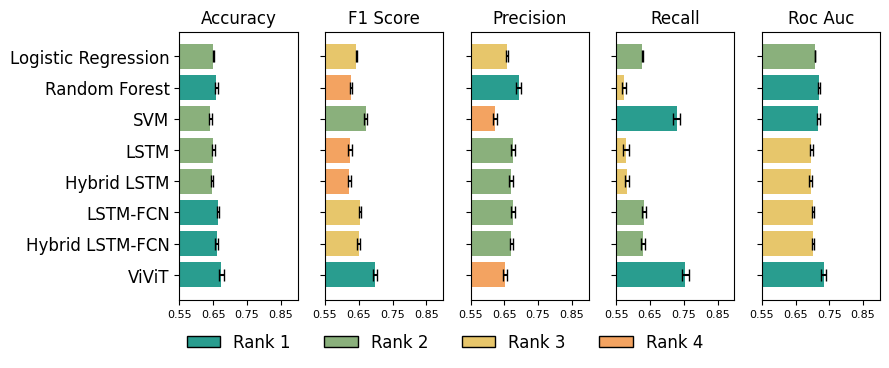

In [6]:
plot_grouped_bar_with_ci(models, df, group_labels_per_metric, 'Concord')

In [7]:
# change the col and row names to these model names
model_names = {
    'logistic': 'Logistic Regression',
    'randomforest': 'Random Forest',
    'svm': 'SVM',
    'lstm-features': 'Hybrid LSTM',
    'lstm': 'LSTM',
    'lstmfcn-features': 'Hybrid LSTM-FCN',
    'lstmfcn': 'LSTM-FCN',
    'vivit': 'ViVit',
}
# set the ordering for the col and row names
model_order = [
    'logistic',
    'randomforest',
    'svm',
    'lstm',
    'lstm-features',
    'lstmfcn',
    'lstmfcn-features',
    'vivit',
]

# for all values in posthoc_results, only remain 3 digits
# e.g. 0.123456 -> 0.123; 1.0 -> 1.00; 0.01123121e-05 -> 0.01e-05； 1 -> 1.00
# store each metric's posthoc result to a csv file
def fmt_three_digits(x):
    # Leave non-numerics (e.g., "ns", "-") alone
    if isinstance(x, (np.integer, int, np.floating, float)):
        s = f"{float(x):.3g}"  # 3 significant digits; uses sci-notation when appropriate
        # If not scientific and no decimal point, pad to .00 (e.g., 1 -> 1.00)
        if 'e' not in s and '.' not in s:
            s = s + '.00'
        return s
    return x


for metric, df in posthoc_results.items():
    # 1) format numbers
    df = df.applymap(fmt_three_digits)

    # 2) rename rows/cols to pretty names
    df = df.rename(index=model_names, columns=model_names)

    # 3) order rows/cols safely (keep only those present)
    desired_idx = [model_names[m] for m in model_order if model_names.get(m) in df.index]
    desired_cols = [model_names[m] for m in model_order if model_names.get(m) in df.columns]
    df = df.loc[desired_idx, desired_cols]

    # 4) save
    df.to_csv(f'./tables/posthoc_dunn_{dataset_name}_{metric}.csv')

C:\Users\Mud\AppData\Local\Temp\ipykernel_47508\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_47508\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_47508\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_47508\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
C:\Users\Mud\AppData\Local\Temp\ipykernel_47508\631486915.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fmt_three_digits)
